# Loading RDKit mols

This tutorial shows how to load the conformers as RDKit `mol` objects. Using RDKit `mol` objects allows you to use RDKit modules to perform analysis on the conformers and generate hand-crafted 3D descriptors. This tutorial assumes that you are familiar with the first tutorial, `01_loading_data.ipynb`, which explains the data structure of the molecule dictionaries.



## Data organization

The RDKit information is contained in the folder `rdkit_folder.tar.gz`, which you can download [here](https://doi.org/10.7910/DVN/JNGTDF). After untarring the folder you will see the files `summary_drugs.json` and `summary_qm9.json`. These files contain all information about the different molecules, except for their individual conformers. 

The folders `qm9` and `drugs` contain individual pickle files for each molecule. Each of these pickle files contains information about all conformers for the given molecule. The conformer information is stored in the form of an RDKit `mol` object.

Because they don't store conformer information, the `summary` files are lightweight and can be easily loaded into memory. They can be used as a sort of directory to filter and choose species of interest. Once you have chosen the molecules you're interested in, you can load them individually through their individual pickle files. 

## Untarring the folder

To untar the RDKit folder, run 
```bash
tar -xvf rdkit_folder.tar.gz
```

in the command line. This should generate a folder called `rdkit_folder`. Note that if you're downloading the tar file from Dataverse using `wget`, it may show up with a different name (usually a 7 digit number). Not to worry - it's the same file, which you can confirm with `md5sum`!

## Example: Choosing SARS-CoV 3CL active molecules

Let's say we're interested in quickly training a model to predict SARS-CoV 3CL inhibition. We may want to use all positive binders (of which there are only a few hundred), but only a subset of negative binders (of which there are hundreds of thousands). To do so, let's first find the molecules we're interested in by loading the `drugs` summary file:

In [17]:
import os
import json
import random
import pickle

# change to where you untarred the rdkit folder
base_path = "/home/saxelrod/rgb_nfs/GEOM_BACKUP"
drugs_file = os.path.join(base_path, "rdkit_folder/summary_drugs.json")

with open(drugs_file, "r") as f:
    drugs_summ = json.load(f)

Each item in the `drugs_summ` dictionary contains summary information as well as the path to the corresponding pickle file (`pickle_path`). (The pickle paths are generally just `drugs/<smiles>.pickle` or `qm9/<smiles>.pickle`, where `<smiles>` is the SMILES string with `/` replaced by `_`. However, there are a couple of exceptions for SMILES strings that are too large to be file names.) 

Here's an example:

In [2]:
example_smiles = list(drugs_summ.keys())[0]
print(example_smiles)
drugs_summ[example_smiles]

BrC(/C=C\c1ccccc1)=N/Nc1nc(N2CCOCC2)nc(N2CCOCC2)n1


{'charge': 0,
 'datasets': ['aid1706', 'plpro'],
 'ensembleenergy': 0.282,
 'ensembleentropy': 7.264,
 'ensemblefreeenergy': -2.166,
 'lowestenergy': -87.80248,
 'pickle_path': 'drugs/BrC(_C=C\\c1ccccc1)=N_Nc1nc(N2CCOCC2)nc(N2CCOCC2)n1.pickle',
 'poplowestpct': 46.745,
 'sars_cov_one_cl_protease_active': 0,
 'sars_cov_one_pl_protease_active': 0,
 'temperature': 298.15,
 'totalconfs': 83,
 'uniqueconfs': 27}

For an in-depth description of the dictionary keys, see the tutorial `01_loading_data.ipynb`.

Now let's find our active molecules and their pickle paths:

In [3]:
active_mol_paths = []

for smiles, sub_dic in drugs_summ.items():
    
    # only select active molecules
    
    if sub_dic.get("sars_cov_one_cl_protease_active") == 1:
        pickle_path = os.path.join(base_path, "rdkit_folder", 
                                   sub_dic.get("pickle_path", ""))
        if os.path.isfile(pickle_path):
            active_mol_paths.append(pickle_path)

print(len(active_mol_paths))


447


We see that there are 447 CoV 3CL hits with paths to pickle files.

Now let's find ~2000 random inactive molecules:


In [4]:
# randomly sample the smiles

random_smiles = list(drugs_summ.keys())
random.shuffle(random_smiles)
random_smiles = random_smiles[:2200]

inactive_mol_paths = []


for smiles in random_smiles:
    
    sub_dic = drugs_summ[smiles]
    
    # only select inactive molecules

    if sub_dic.get("sars_cov_one_cl_protease_active") == 0:
        # add the prefix "rdkit_folder" to the path
        pickle_path = os.path.join(base_path, "rdkit_folder", 
                                   sub_dic.get("pickle_path", ""))
        # check if the path exists
        if os.path.isfile(pickle_path):
            inactive_mol_paths.append(pickle_path)

print(len(inactive_mol_paths))



2109


Finally, let's load all these pickle files into one dictionary:

In [5]:
sample_dic = {}
for mol_path in [*active_mol_paths, *inactive_mol_paths]:
    with open(mol_path, "rb") as f:
        dic = pickle.load(f)
        
    # set the keys of the new dictionary to
    # be SMILES strings
    sample_dic.update({dic["smiles"]: dic})
    
print(len(sample_dic))

2556


Here's an example of one of our dictionary items:

In [6]:
sample_smiles = list(sample_dic.keys())[0]
sample_dic[sample_smiles]

{'totalconfs': 69,
 'temperature': 298.15,
 'uniqueconfs': 34,
 'lowestenergy': -74.9338,
 'poplowestpct': 51.989,
 'ensembleenergy': 0.213,
 'ensembleentropy': 5.574,
 'ensemblefreeenergy': -1.662,
 'sars_cov_one_pl_protease_active': 0,
 'sars_cov_one_cl_protease_active': 1,
 'charge': 0,
 'datasets': ['aid1706', 'plpro'],
 'conformers': [{'geom_id': 86429709,
   'set': 1,
   'degeneracy': 6,
   'totalenergy': -74.93380308,
   'relativeenergy': 0.0,
   'boltzmannweight': 0.51989,
   'conformerweights': [0.08671, 0.0867, 0.0867, 0.08667, 0.08664, 0.08647],
   'rd_mol': <rdkit.Chem.rdchem.Mol at 0x7ff6c37831b0>},
  {'geom_id': 86429710,
   'set': 2,
   'degeneracy': 6,
   'totalenergy': -74.93355597,
   'relativeenergy': 0.155,
   'boltzmannweight': 0.4003,
   'conformerweights': [0.06676, 0.06674, 0.06673, 0.06672, 0.06671, 0.06664],
   'rd_mol': <rdkit.Chem.rdchem.Mol at 0x7ff6b30de0b0>},
  {'geom_id': 86429711,
   'set': 3,
   'degeneracy': 6,
   'totalenergy': -74.93120196,
   'rela

For an in-depth description of the dictionary keys, see the tutorial `01_loading_data.ipynb`.

## Performing analysis with RDKit

Having molecules available as RDKit objects allows us to perform all sorts of analysis, from visualization to generating descriptors. Let's look at a few examples.

First, we can easily visualize different conformers:

Boltzmann weight: 0.51989
Degeneracy: 6
Relative energy: 0.0


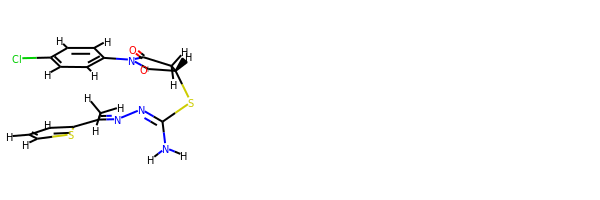

Boltzmann weight: 0.4003
Degeneracy: 6
Relative energy: 0.155


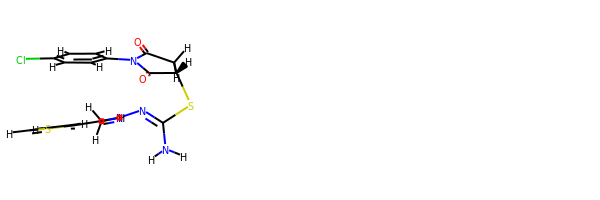

Boltzmann weight: 0.03312
Degeneracy: 6
Relative energy: 1.632


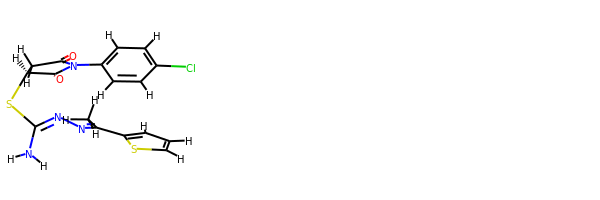

Boltzmann weight: 0.02044
Degeneracy: 4
Relative energy: 1.678


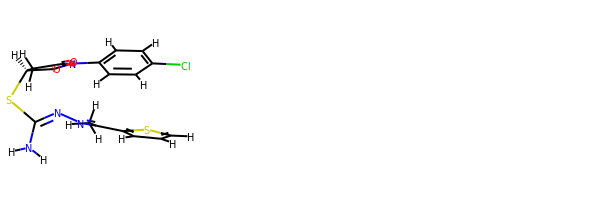

Boltzmann weight: 0.00728
Degeneracy: 3
Relative energy: 2.119


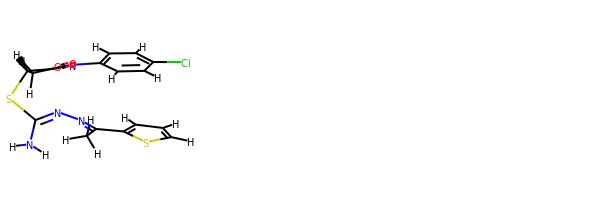

Boltzmann weight: 0.00242
Degeneracy: 1
Relative energy: 2.122


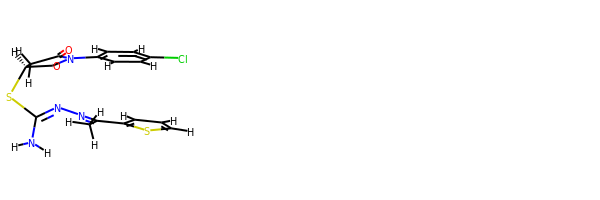

Boltzmann weight: 0.01308
Degeneracy: 6
Relative energy: 2.183


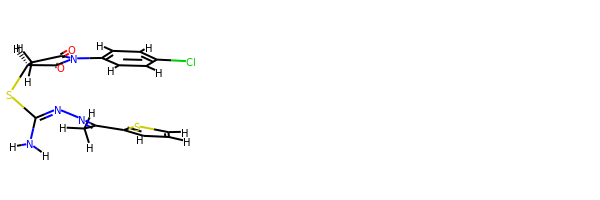

Boltzmann weight: 0.00041
Degeneracy: 1
Relative energy: 3.168


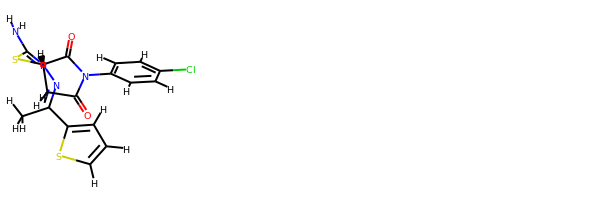

Boltzmann weight: 0.00028
Degeneracy: 1
Relative energy: 3.405


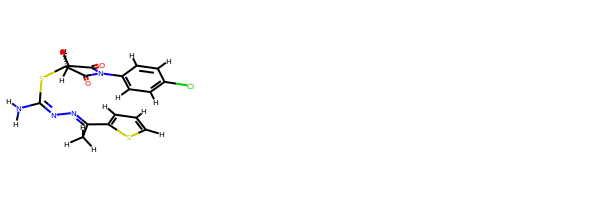

Boltzmann weight: 0.00017
Degeneracy: 1
Relative energy: 3.708


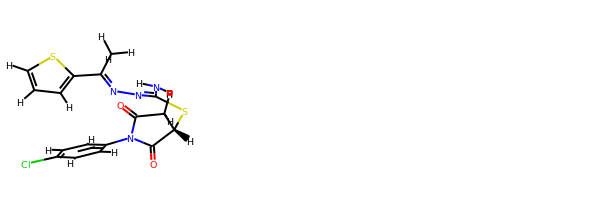

Boltzmann weight: 0.00016
Degeneracy: 1
Relative energy: 3.735


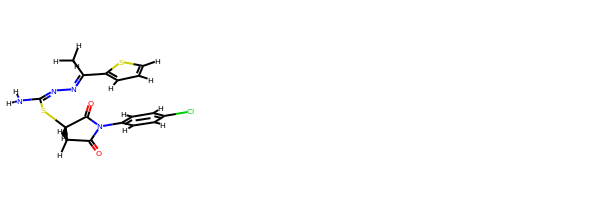

Boltzmann weight: 0.00041
Degeneracy: 3
Relative energy: 3.822


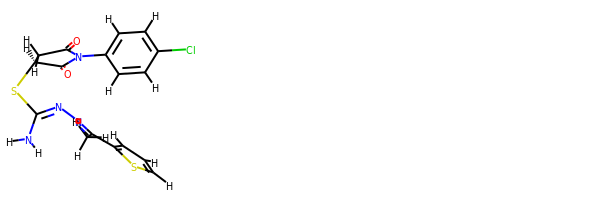

Boltzmann weight: 0.00014
Degeneracy: 1
Relative energy: 3.829


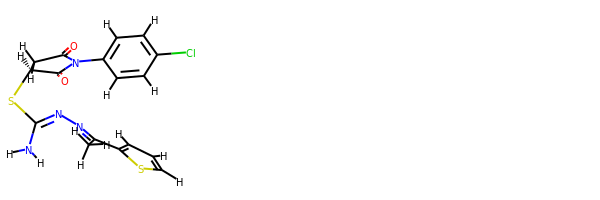

Boltzmann weight: 0.00038
Degeneracy: 3
Relative energy: 3.875


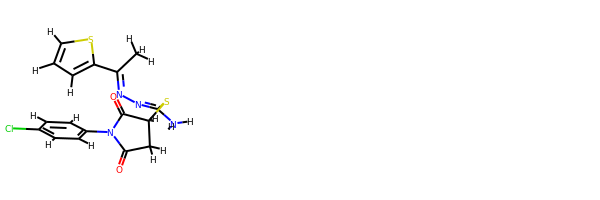

Boltzmann weight: 0.00011
Degeneracy: 1
Relative energy: 3.971


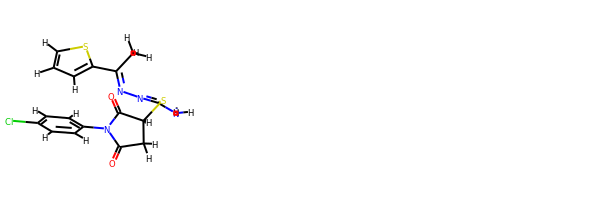

Boltzmann weight: 0.0002
Degeneracy: 2
Relative energy: 4.02


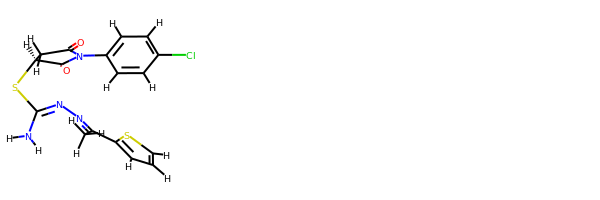

Boltzmann weight: 0.0001
Degeneracy: 1
Relative energy: 4.031


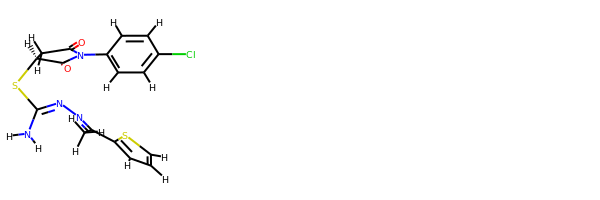

Boltzmann weight: 9e-05
Degeneracy: 1
Relative energy: 4.059


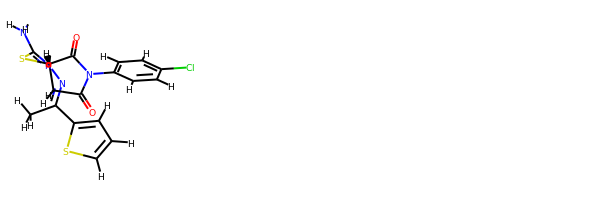

Boltzmann weight: 9e-05
Degeneracy: 1
Relative energy: 4.087


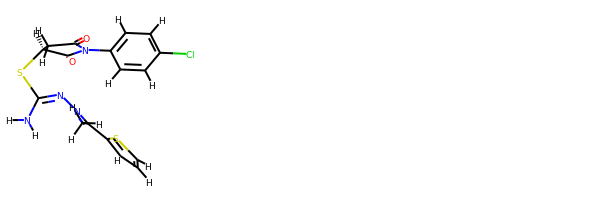

Boltzmann weight: 8e-05
Degeneracy: 1
Relative energy: 4.142


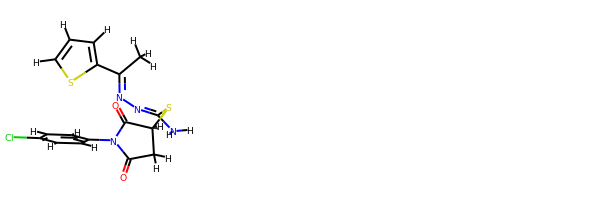

Boltzmann weight: 8e-05
Degeneracy: 1
Relative energy: 4.178


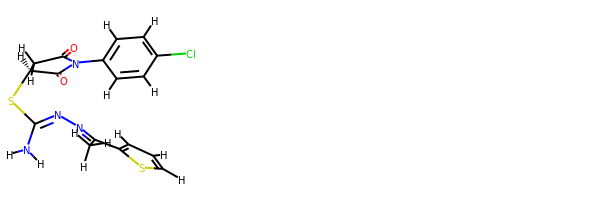

Boltzmann weight: 7e-05
Degeneracy: 1
Relative energy: 4.222


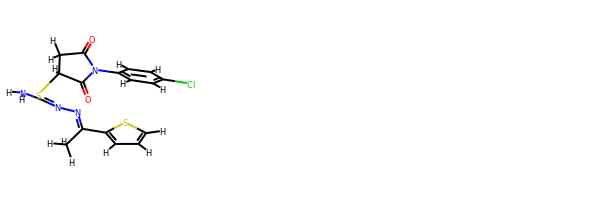

Boltzmann weight: 0.00014
Degeneracy: 2
Relative energy: 4.227


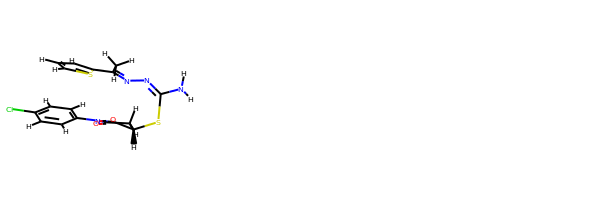

Boltzmann weight: 7e-05
Degeneracy: 1
Relative energy: 4.229


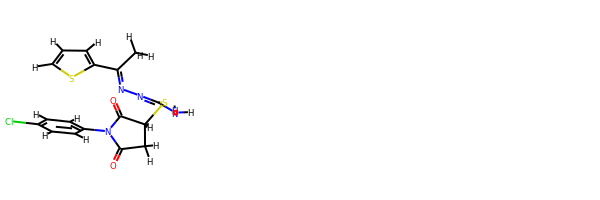

Boltzmann weight: 6e-05
Degeneracy: 1
Relative energy: 4.297


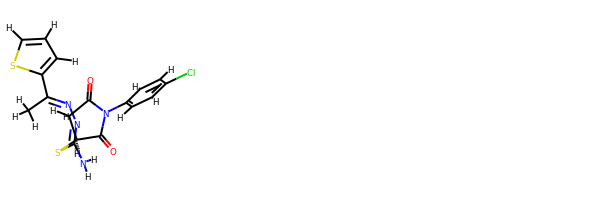

Boltzmann weight: 6e-05
Degeneracy: 1
Relative energy: 4.299


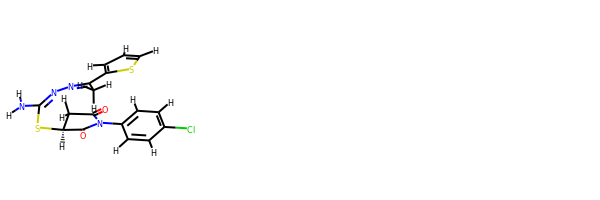

Boltzmann weight: 0.00012
Degeneracy: 2
Relative energy: 4.317


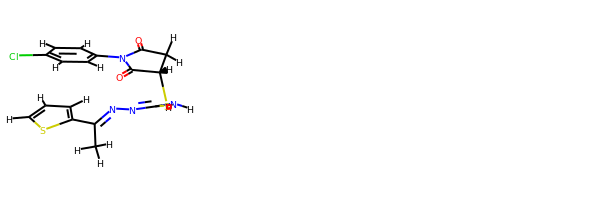

Boltzmann weight: 6e-05
Degeneracy: 1
Relative energy: 4.328


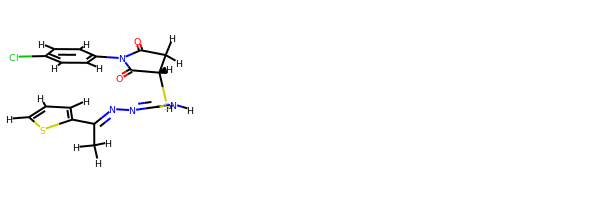

Boltzmann weight: 9e-05
Degeneracy: 2
Relative energy: 4.478


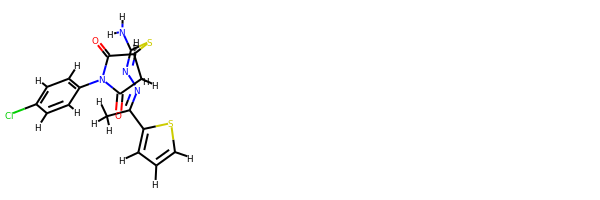

Boltzmann weight: 4e-05
Degeneracy: 1
Relative energy: 4.599


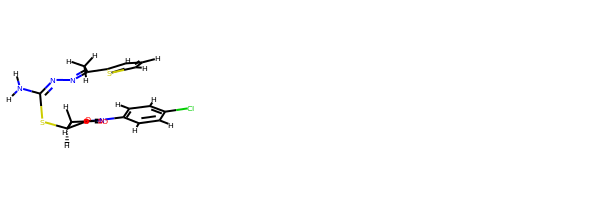

Boltzmann weight: 4e-05
Degeneracy: 2
Relative energy: 4.915


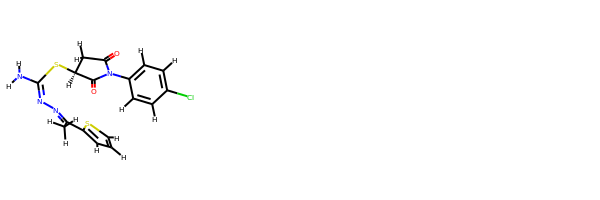

Boltzmann weight: 1e-05
Degeneracy: 1
Relative energy: 5.498


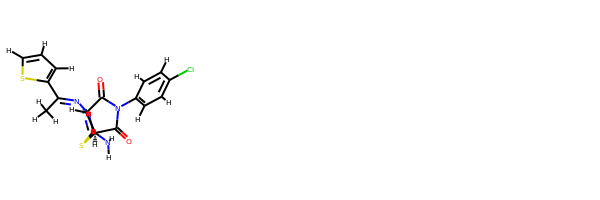

Boltzmann weight: 1e-05
Degeneracy: 2
Relative energy: 5.763


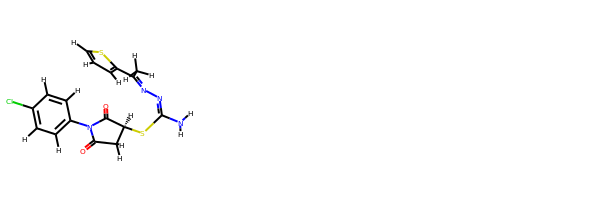

Boltzmann weight: 0.0
Degeneracy: 1
Relative energy: 5.79


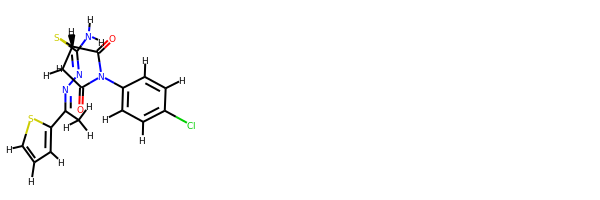

In [7]:
from IPython.display import display

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdMolDescriptors import CalcWHIM
from rdkit.Chem.rdmolfiles import MolToPDBFile
from rdkit.Chem.Draw import MolsToGridImage

from e3fp.pipeline import fprints_from_mol

from matplotlib import pyplot as plt
import numpy as np

confs = sample_dic[sample_smiles]['conformers']

for conf in confs:
    mol = conf['rd_mol']
    weight = conf["boltzmannweight"]
    degen = conf["degeneracy"]
    en = conf["relativeenergy"]
    
    print(f"Boltzmann weight: {weight}")
    print(f"Degeneracy: {degen}")
    print(f"Relative energy: {en}")
    display(MolsToGridImage([mol]))

You can also rotate the conformers to maximize their overlap. This makes it easier to see how they differ:

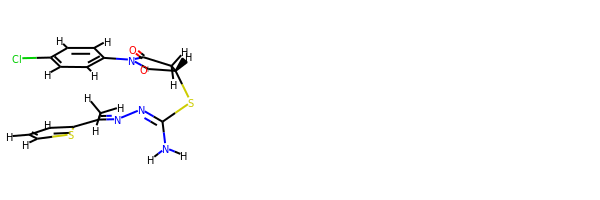

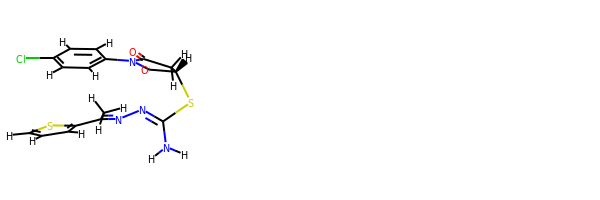

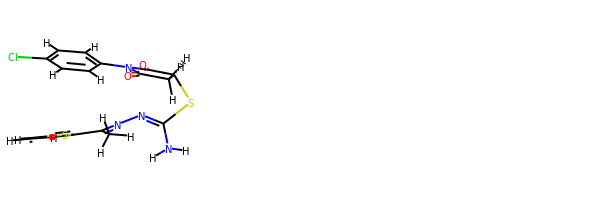

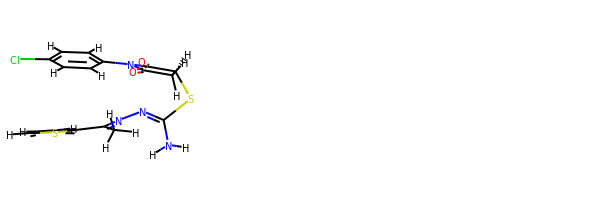

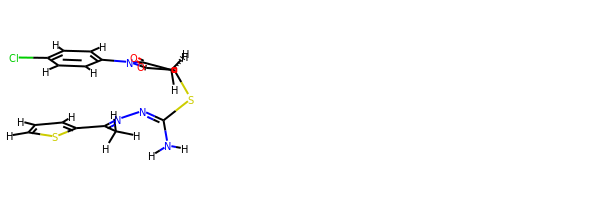

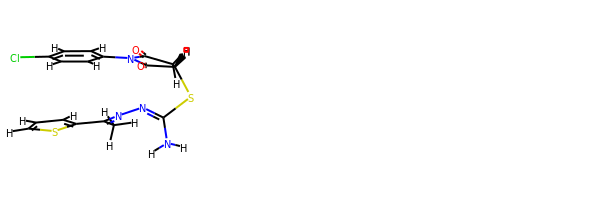

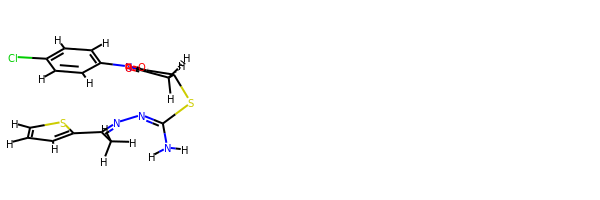

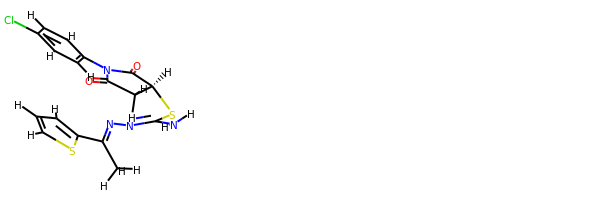

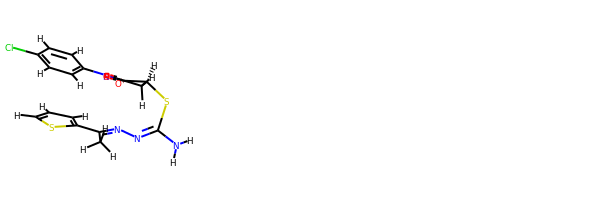

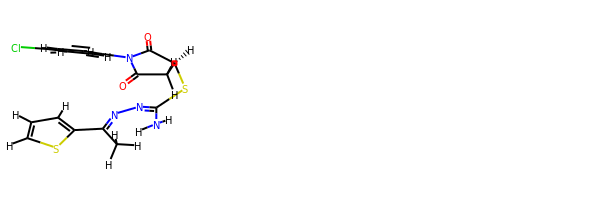

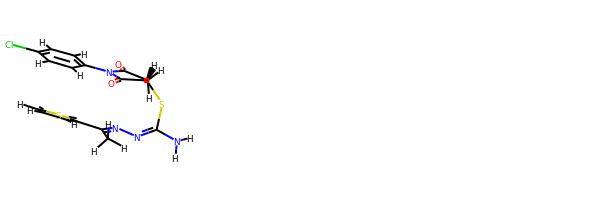

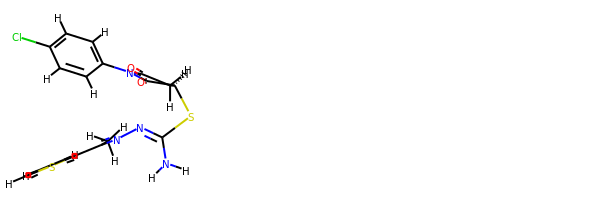

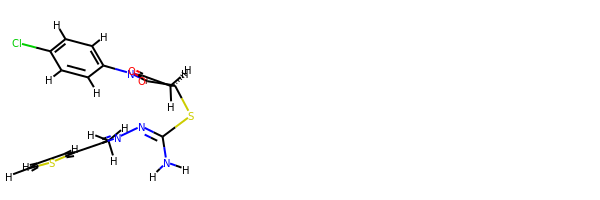

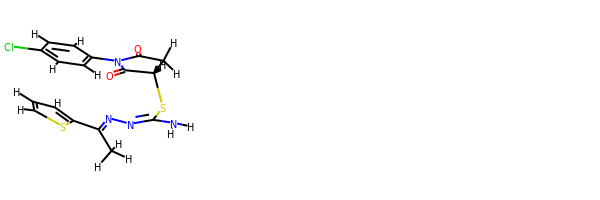

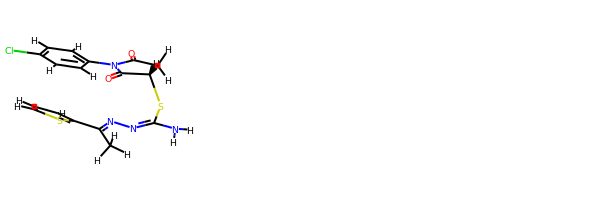

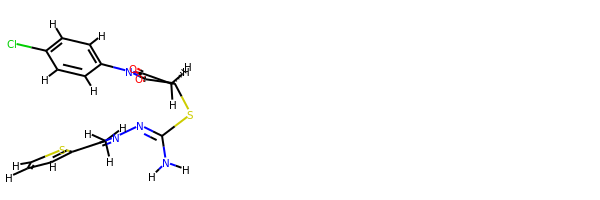

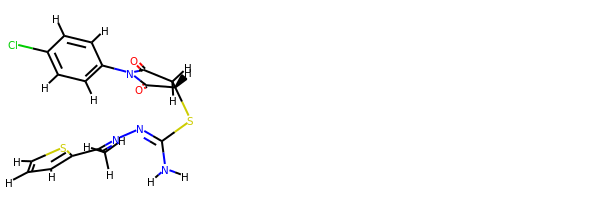

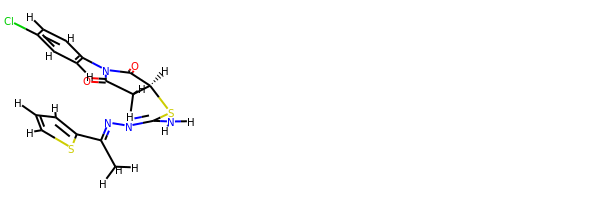

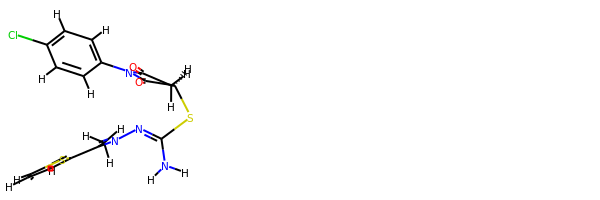

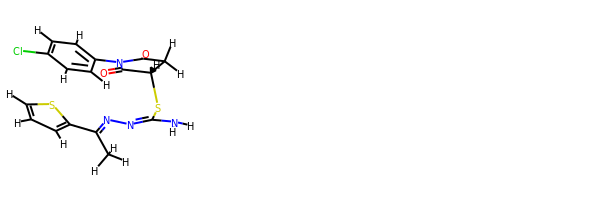

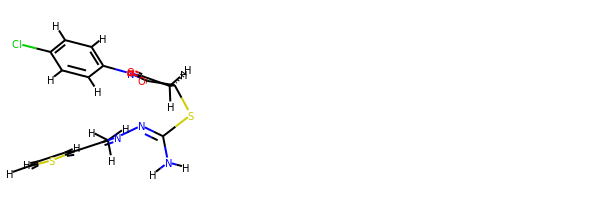

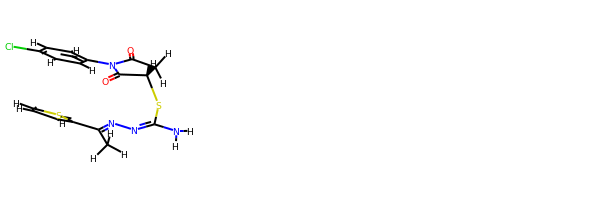

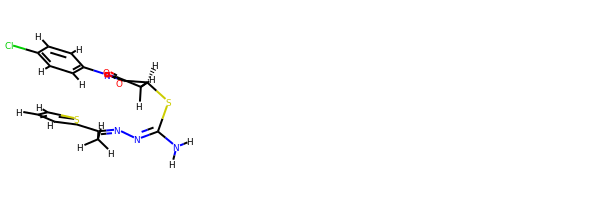

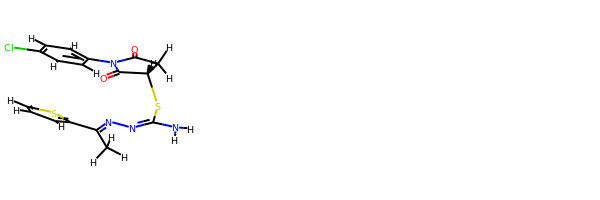

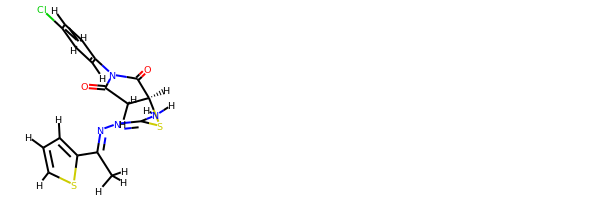

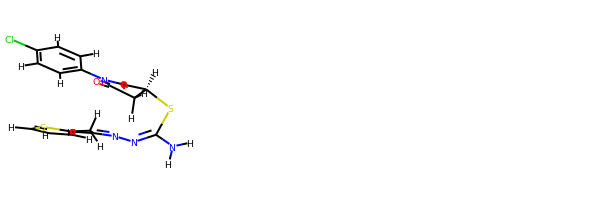

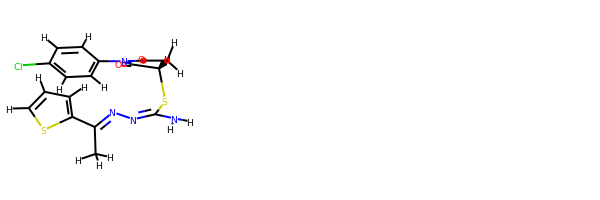

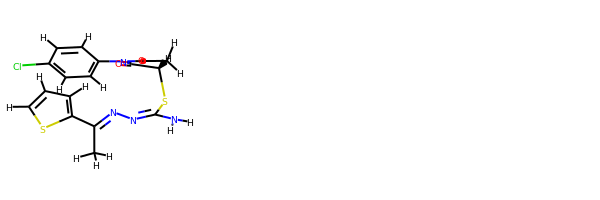

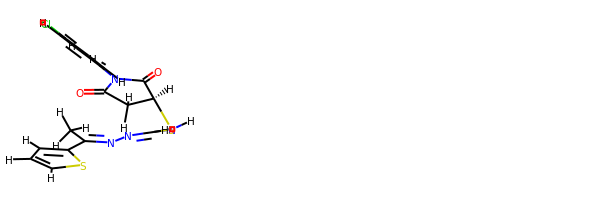

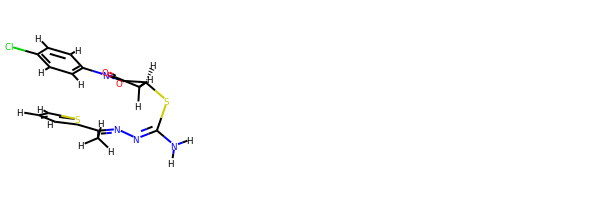

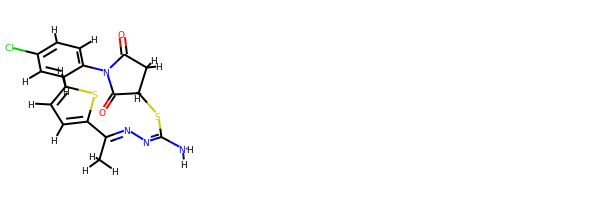

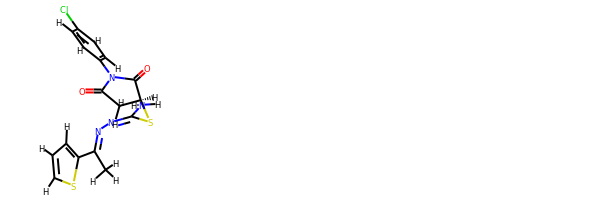

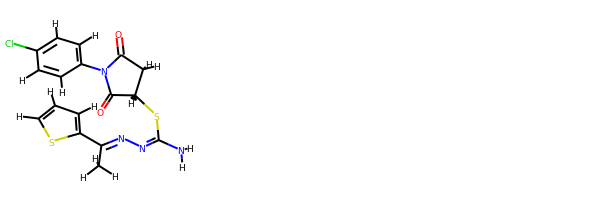

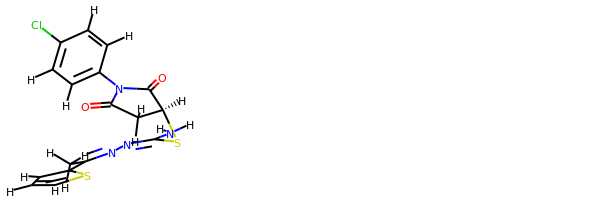

In [8]:
rd_mols = [conf['rd_mol'] for conf in confs]

for i, mol in enumerate(rd_mols[1:]):
    # align the mol to maximiz overlap with the first one
    Chem.rdMolAlign.AlignMol(prbMol=mol, refMol=rd_mols[0])
    rd_mols[i+1] = mol
for mol in rd_mols:
    display(MolsToGridImage([mol]))

Note that because every CREST conformer gets its own `mol` object, every `mol` object has only one RDKit conformer:

In [9]:
print(confs[0]["rd_mol"].GetConformers())
print(confs[1]["rd_mol"].GetConformers())

(<rdkit.Chem.rdchem.Conformer object at 0x7ff6422a8e10>,)
(<rdkit.Chem.rdchem.Conformer object at 0x7ff6422a8e10>,)


Next, we can generated 2D and 3D descriptors. The Morgan fingerprint of each conformer should be identical, unless different conformers have different connectivities:

In [10]:
morgan_fps = []
for conf in confs:
    rd_mol = conf["rd_mol"]
    fp = AllChem.GetMorganFingerprintAsBitVect(rd_mol, 2, nBits=1024)
    morgan_fps.append(fp)

# the Morgan fingerprints should be the same unless
# connectivity has changed
all([fp == morgan_fps[0] for fp in morgan_fps])

True

On the other hand, 3D descriptors will generally be different. For example, let's look at the WHIM descriptor and the E3FP descriptors:

2020-12-02 18:24:54,310|INFO|Generating fingerprints for conf_0.
2020-12-02 18:24:54,399|INFO|Generated 1 fingerprints for conf_0.
2020-12-02 18:24:54,400|INFO|Generating fingerprints for conf_1.
2020-12-02 18:24:54,487|INFO|Generated 1 fingerprints for conf_1.
2020-12-02 18:24:54,489|INFO|Generating fingerprints for conf_2.
2020-12-02 18:24:54,576|INFO|Generated 1 fingerprints for conf_2.
2020-12-02 18:24:54,578|INFO|Generating fingerprints for conf_3.
2020-12-02 18:24:54,666|INFO|Generated 1 fingerprints for conf_3.
2020-12-02 18:24:54,668|INFO|Generating fingerprints for conf_4.
2020-12-02 18:24:54,758|INFO|Generated 1 fingerprints for conf_4.
2020-12-02 18:24:54,759|INFO|Generating fingerprints for conf_5.
2020-12-02 18:24:54,847|INFO|Generated 1 fingerprints for conf_5.
2020-12-02 18:24:54,849|INFO|Generating fingerprints for conf_6.
2020-12-02 18:24:54,937|INFO|Generated 1 fingerprints for conf_6.
2020-12-02 18:24:54,938|INFO|Generating fingerprints for conf_7.
2020-12-02 18:24:5

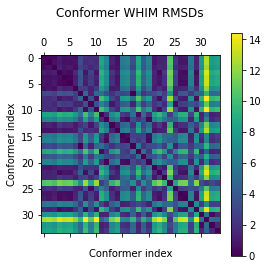

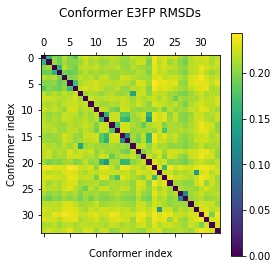

In [11]:
whims = []
e3fps = []

for i, conf in enumerate(confs):
    rd_mol = conf["rd_mol"]
    whim = np.array(CalcWHIM(rd_mol))
    whims.append(whim)
    
    # e3fp mols must have names
    
    rd_mol.SetProp("_Name", "conf_{}".format(i))
    fprint_params = {"bits": 1024}
    fp = fprints_from_mol(rd_mol, fprint_params=fprint_params);
    fp_as_vec = fp[0].to_bitvector()
    e3fps.append(fp_as_vec.toarray().astype('int'))


# calculate the RMSDs between the vectors

whim_rmsds = np.zeros((len(whims), len(whims)))
e3fp_rmsds = np.zeros((len(whims), len(whims)))


for i in range(len(whims)):
    for j in range(len(whims)):
        whim_rmsd = np.mean((whims[i] - whims[j]) ** 2) ** 0.5
        whim_rmsds[i, j] = whim_rmsd
   
        e3fp_rmsd = np.mean((e3fps[i] - e3fps[j]) ** 2) ** 0.5
        e3fp_rmsds[i, j] = e3fp_rmsd
        
# see how similar the descriptors of the conformers are 

plt.matshow(whim_rmsds)
plt.colorbar()
plt.xlabel("\nConformer index")
plt.ylabel("Conformer index")
plt.title("Conformer WHIM RMSDs\n")
plt.show()

plt.matshow(e3fp_rmsds)
plt.colorbar()
plt.xlabel("\nConformer index")
plt.ylabel("Conformer index")
plt.title("Conformer E3FP RMSDs\n")
plt.show()

We can see a summary of the molecule using `Chem.MolToMolBlock`:

In [12]:
print(Chem.MolToMolBlock(confs[0]["rd_mol"]))

conf_0
     RDKit          3D

 41 43  0  0  0  0  0  0  0  0999 V2000
   -0.2180   -1.1276    2.1985 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.3125   -1.4587    0.7398 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.6535   -1.4378   -0.1002 N   0  0  0  0  0  0  0  0  0  0  0  0
    1.8602   -0.9337    0.1723 N   0  0  0  0  0  0  0  0  0  0  0  0
    2.9457   -1.5671    0.3408 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.1069   -2.9072    0.5211 N   0  0  0  0  0  0  0  0  0  0  0  0
    4.0357   -3.2842    0.4374 H   0  0  0  0  0  0  0  0  0  0  0  0
    2.3484   -3.4966    0.2142 H   0  0  0  0  0  0  0  0  0  0  0  0
    4.3964   -0.5685    0.4348 S   0  0  0  0  0  0  0  0  0  0  0  0
    3.6127    1.0283    0.0471 C   0  0  2  0  0  0  0  0  0  0  0  0
    2.2176    1.1243    0.6704 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.9772    1.1222    1.8516 O   0  0  0  0  0  0  0  0  0  0  0  0
    1.3564    1.5986   -0.3351 N   0  0  0  0  0  0  0  0  0  0  0  0
    1.9625    1.730

We can extract the `xyz`:


In [13]:
rd_mol = confs[0]["rd_mol"]
atoms = rd_mol.GetAtoms()

# get the atomic numbers

atom_nums = []
for atom in atoms:
    atom_nums.append(atom.GetAtomicNum())

# get the coordinates

rd_conf = rd_mol.GetConformers()[0]
positions = rd_conf.GetPositions()

xyz = []
for atom_num, position in zip(atom_nums, positions):
    xyz.append([atom_num, *position])

# convert to numpy array
xyz = np.array(xyz)

xyz

array([[ 6.        , -0.2180364 , -1.12756598,  2.19850445],
       [ 6.        , -0.31246442, -1.45867693,  0.73981404],
       [ 7.        ,  0.65347183, -1.43775094, -0.1001703 ],
       [ 7.        ,  1.86018813, -0.93373644,  0.17233974],
       [ 6.        ,  2.94574118, -1.56708074,  0.34075454],
       [ 7.        ,  3.10687685, -2.907197  ,  0.52114409],
       [ 1.        ,  4.03570318, -3.28421378,  0.43741578],
       [ 1.        ,  2.34842634, -3.49656296,  0.21418644],
       [16.        ,  4.39644003, -0.56847727,  0.43478417],
       [ 6.        ,  3.61268091,  1.02832437,  0.04705635],
       [ 6.        ,  2.21763587,  1.12429762,  0.67035455],
       [ 8.        ,  1.97718728,  1.12215972,  1.85158944],
       [ 7.        ,  1.35635078,  1.59857202, -0.33514643],
       [ 6.        ,  1.96250618,  1.73014736, -1.56541061],
       [ 8.        ,  1.44072556,  2.15088773, -2.56293845],
       [ 6.        ,  3.40669751,  1.27932394, -1.43488228],
       [ 1.        ,  4.

And we can extract atom and bond features:

In [14]:
atom = atoms[3]
h_bonds = [bond for bond in atom.GetBonds()
            if any([bond.GetBeginAtom().GetAtomicNum()==1,
                    bond.GetEndAtom().GetAtomicNum()==1])]

atom_features = {"atom_type": atom.GetAtomicNum(), 
                "formal_charge": atom.GetFormalCharge(),
                "hybridization": atom.GetHybridization().name.lower(),
                "is_aromatic": atom.GetIsAromatic(),
                "num_bonds": len(atom.GetBonds()),
                "num_h_bonds": len(h_bonds),
                "chirality": atom.GetChiralTag().name.lower(),
                "mass": atom.GetMass()}

print("Some features of atom 3:")
display(atom_features)




bond = rd_mol.GetBonds()[24]
in_ring_size = -1
for size in range(10):
    if bond.IsInRingSize(size):
        in_ring_size = size
        
bond_features = {"indices": [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()],
                "type": bond.GetBondType().name.lower(),
                "stereo": bond.GetStereo().name.lower().split("stereo")[-1],
                "conjugated": bond.GetIsConjugated(),
                "in_ring": bond.IsInRing(),
                "in_ring_size": in_ring_size}

print("\n")
print("Some features of bond 24:")
display(bond_features)



Some features of atom 3:


{'atom_type': 7,
 'formal_charge': 0,
 'hybridization': 'sp2',
 'is_aromatic': False,
 'num_bonds': 2,
 'num_h_bonds': 0,
 'chirality': 'chi_unspecified',
 'mass': 14.007}



Some features of bond 24:


{'indices': [18, 19],
 'type': 'aromatic',
 'stereo': 'none',
 'conjugated': True,
 'in_ring': True,
 'in_ring_size': 6}

## Exporting to PDB

You may be interested in generating PDB files for the molecules, for example to perform docking. This can be done easily with RDKit:

In [15]:
MolToPDBFile(confs[0]["rd_mol"], "test.pdb")

Let's see what it looks like:

In [16]:
with open("test.pdb", "r") as f:
    pdb_text = f.read()
print(pdb_text)

COMPND    conf_0
HETATM    1  C1  UNL     1      -0.218  -1.128   2.199  1.00  0.00           C  
HETATM    2  C2  UNL     1      -0.312  -1.459   0.740  1.00  0.00           C  
HETATM    3  N1  UNL     1       0.653  -1.438  -0.100  1.00  0.00           N  
HETATM    4  N2  UNL     1       1.860  -0.934   0.172  1.00  0.00           N  
HETATM    5  C3  UNL     1       2.946  -1.567   0.341  1.00  0.00           C  
HETATM    6  N3  UNL     1       3.107  -2.907   0.521  1.00  0.00           N  
HETATM    7  H1  UNL     1       4.036  -3.284   0.437  1.00  0.00           H  
HETATM    8  H2  UNL     1       2.348  -3.497   0.214  1.00  0.00           H  
HETATM    9  S1  UNL     1       4.396  -0.568   0.435  1.00  0.00           S  
HETATM   10  C4  UNL     1       3.613   1.028   0.047  1.00  0.00           C  
HETATM   11  C5  UNL     1       2.218   1.124   0.670  1.00  0.00           C  
HETATM   12  O1  UNL     1       1.977   1.122   1.852  1.00  0.00           O  
HETATM   13

# A note on SMILES pre-processsing

Some of the molecules' SMILES are not the same as they were in the original datasets, because they were originally given as salts with a metal cation, halogen anion, or some other species. In other cases the SMILES strings contained species in acid (e.g. `XXX.Cl`, which means the molecule `XXX` in hydrochloric acid). This means that, if `XXX` contained nitrogen, then one of the nitrogens would be protonated.

We de-salted the SMILES strings and fixed the ionization states of species in acids, leading to SMILES strings that are not always the same as the originals. In these cases we have an additional key, `uncleaned_smiles`, which contains all possible versions of the original SMILES. For example, if the SMILES was originally of the form `XXXN.Cl`, then `smiles=XXX[NH+]` and `uncleaned_smiles = [XXXN.Cl, XXXN]`. The new SMILES has a protonated nitrogen, and its `uncleaned_smiles` contains both `XXXN.Cl` (the molecule in HCl) and `XXXN` (the molecule by itself).

Here's an example of the `uncleaned_smiles` key:

Brc1ccc(-c2csc(N[NH2+]C3=NCCCCC3)n2)cc1


{'charge': 1,
 'ensembleenergy': 0.38,
 'ensembleentropy': 3.824,
 'ensemblefreeenergy': -1.14,
 'lowestenergy': -59.93554,
 'pickle_path': 'drugs/Brc1ccc(-c2csc(N[NH2+]C3=NCCCCC3)n2)cc1.pickle',
 'poplowestpct': 55.347,
 'sars_cov_one_cl_protease_active': 0,
 'sars_cov_one_pl_protease_active': 0,
 'temperature': 298.15,
 'totalconfs': 34,
 'uncleaned_smiles': ['Brc1ccc(-c2csc(NNC3=NCCCCC3)n2)cc1',
  'Br.Brc1ccc(-c2csc(NNC3=NCCCCC3)n2)cc1'],
 'uniqueconfs': 18}

Original:


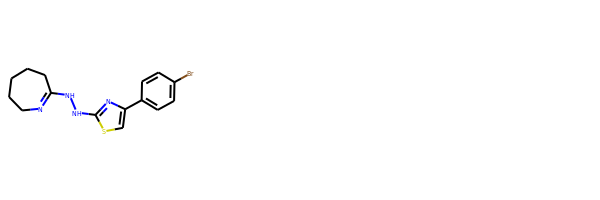

Original:


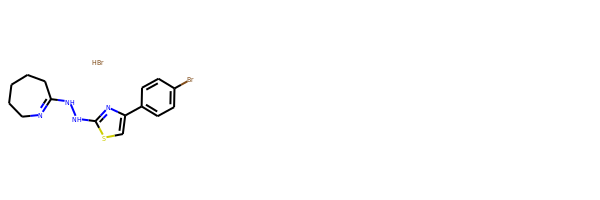

Cleaned:


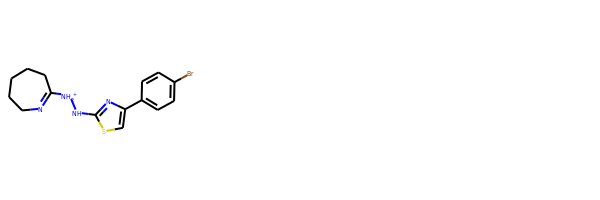

In [17]:
smiles = 'Brc1ccc(-c2csc(N[NH2+]C3=NCCCCC3)n2)cc1'
print(smiles)
display(drugs_summ[smiles])

uncleaned_smiles = drugs_summ[smiles]['uncleaned_smiles']
mol = Chem.MolFromSmiles(smiles)

for other_smiles in uncleaned_smiles:
    uncleaned_mol =  Chem.MolFromSmiles(other_smiles)
    print("Original:")
    display(MolsToGridImage([uncleaned_mol]))

print("Cleaned:")
display(MolsToGridImage([mol]))

- Here we see two possible original SMILES strings: one with the molecule in HBr and one with the molecule by itself. The SMILES string we use is the molecule without HBr and with a protonated nitrogen.

- If you want to compare the SMILES in our data to the SMILES in another dataset, you can go through each string in `uncleaned_smiles` and compare it to `Chem.MolToSmiles(Chem.MolFromSmiles(<their_smiles>))` for theirs. If one of them matches then the SMILES strings are in both datasets. Note that our SMILES are already in canonical form, and application of `Chem.MolToSmiles(Chem.MolFromSmiles())` converts `<their_smiles>` to canonical form, too.

# A note on reactivity

- Some conformers may have graphs that differ from each other. Here are some examples:

##### Example 1

The target structure is: 
Smiles: CN(C)CP(=O)(O)CN(C)C=O


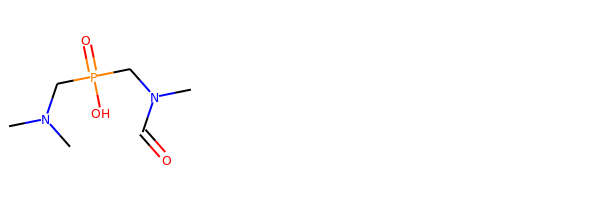

Some conformers are:
Smiles: C=[N+](C)C=O.CN(C)CP([O-])O


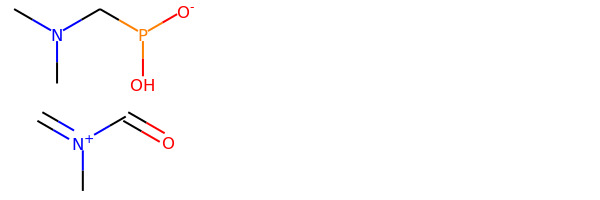

Smiles: C=[N+](C)C.C=[N+](C)C=O.O=PO


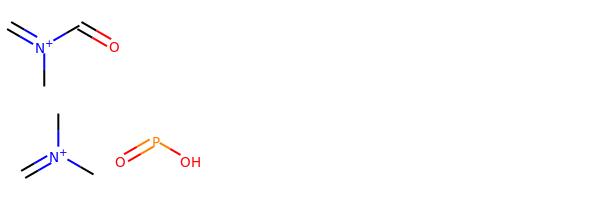

Smiles: CN(C)C[P@](=O)(O)CN(C)C=O


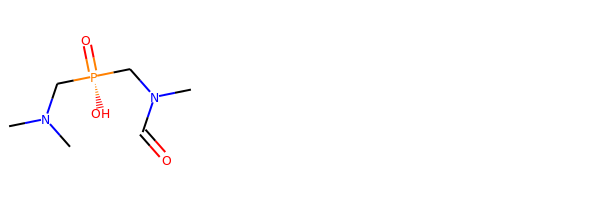

In [70]:
smiles = "CN(C)CP(=O)(O)CN(C)C=O"
pickle_path = os.path.join(base_path, 'rdkit_folder', drugs_summ[smiles]['pickle_path'])
with open(pickle_path, 'rb') as f:
    pick = pickle.load(f)

actual_smiles = []
for conf in pick['conformers']:
    mol = conf['rd_mol']
    actual_smiles.append(Chem.MolToSmiles(
        Chem.MolFromSmiles(Chem.MolToSmiles(mol))))
actual_smiles = list(set(actual_smiles))

print("The target structure is: ")
mol = Chem.MolFromSmiles(smiles)
print(f"Smiles: {smiles}")
display(MolsToGridImage([mol]))

print("Some conformers are:")
for smiles in actual_smiles:
    mol = Chem.MolFromSmiles(smiles)
    print(f"Smiles: {smiles}")
    display(MolsToGridImage([mol]))

#### Analysis
- Here we see reactivity! The CREST simulations actually lead to dissociation of the molecule
- Here it is clear that we should not consider the conformers as actual conformers, because they're really products of a dissociation reaction

##### Example 2

The target structure is: 
Smiles: Cc1ncsc1C(=O)N1CCNC(=O)C1


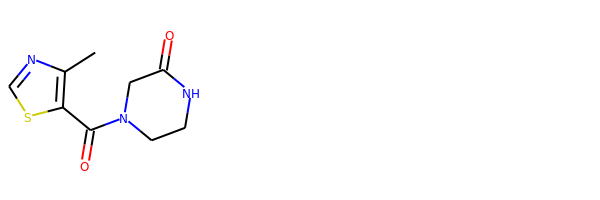

Some conformers are:
Smiles: CC1=NC=[S+]/C1=C(/[O-])N1CCNC(=O)C1


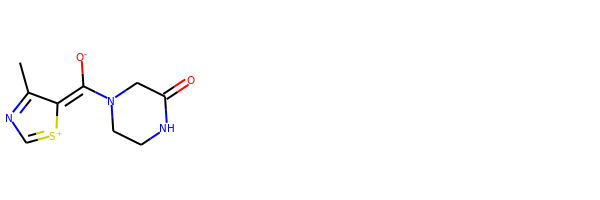

Smiles: CC1=NC=[S+]/C1=C(\[O-])N1CCNC(=O)C1


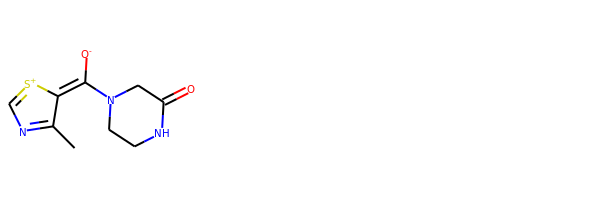

In [18]:
smiles = "Cc1ncsc1C(=O)N1CCNC(=O)C1"
pickle_path = os.path.join(base_path, 'rdkit_folder', drugs_summ[smiles]['pickle_path'])
with open(pickle_path, 'rb') as f:
    pick = pickle.load(f)

actual_smiles = []
for conf in pick['conformers']:
    mol = conf['rd_mol']
    actual_smiles.append(Chem.MolToSmiles(
        Chem.MolFromSmiles(Chem.MolToSmiles(mol))))
actual_smiles = list(set(actual_smiles))

print("The target structure is: ")
mol = Chem.MolFromSmiles(smiles)
print(f"Smiles: {smiles}")
display(MolsToGridImage([mol]))

print("Some conformers are:")
for smiles in actual_smiles:
    mol = Chem.MolFromSmiles(smiles)
    print(f"Smiles: {smiles}")
    display(MolsToGridImage([mol]))

#### Analysis
- The original SMILES contains a double-bonded central oxygen and a single-bonded sulfur. The new SMILES strings are resonance structures of the original, containing a double-bonded S+, single-bonded O-, and a double bond one carbon away from O-. 

- The new double bond means that the new SMILES strings can have either E or Z form, and in fact the conformers contain a mixture of both! Hence **the conformers don't all have the same graph**.

- It is not necessarily clear if we should consider these "conformers" or not. On the one hand, usually conformers are geometries that rotate around rotable bonds, and do not rotate around double bonds. So having a mixture of E and Z "conformers" would mean they are not really conformers.

- On the other hand, the new SMILES strings are just resonance structures of the original SMILES, and the original SMILES has no double-bond for which we need to define E or Z.

- You could argue that the issue is really with `xyz2mol`, which assigned resonance structure SMILES instead of the original SMILES.

- So ultimately it's up to you to decide what to do with cases like this!

